In [52]:
import numpy as np
import regex as re
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import utils

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [46]:
df = pd.read_pickle('./data/dataframes/outer_merged_normalized_deduped.pkl')
df.head()

,newsgroup,subject
0,autos,saturn's pricing policy
10,autos,are bmw's worth the price
12,autos,re headlights problem
14,autos,left turn signal won't stop automaticaly
16,autos,what is volvo


In [47]:
all_categories = ['sport', 'autos', 'religion', 'comp_elec', 'sci_med', 'seller', 'politics']
# We'll use all
target_categories = ['sport', 'autos', 'religion', 'comp_elec', 'sci_med', 'seller', 'politics']

### Augment our data

In [48]:
# But still need to fit the tokenizer on our original text to keep same vocak
max_tokens = 50 
X = np.array([subject for subject in df['subject']])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [49]:
df['subject'] = df['subject'].apply(lambda x: utils.replace_rejoin(x))

In [50]:
# container for sentences
X = np.array([subject for subject in df['subject']])
# container for sentences
y = np.array([subject for subject in df['newsgroup']])

In [51]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(df['newsgroup'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

classes = np.unique(y_train)
mapping = dict(zip(classes, target_categories))

len(X_train), len(X_test), classes, mapping

(6359,
 2120,
 array([0, 1, 2, 3, 4, 5, 6]),
 {0: 'sport',
  1: 'autos',
  2: 'religion',
  3: 'comp_elec',
  4: 'sci_med',
  5: 'seller',
  6: 'politics'})

In [54]:
## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)

print(X_train_vect[:3])

X_train_vect.shape, X_test_vect.shape

[[ 139  403  143 1947    2 7656    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [8630   10 4127 4128    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   8  459 3023 4801  115   14    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


((6359, 50), (2120, 50))

In [56]:
# Should match previous runs
print("Vocab Size : {}".format(len(tokenizer.word_index)))

Vocab Size : 9734


In [57]:
path = './glove.6B.50d.txt'
glove_embeddings = {}
with open(path) as f:
    for line in f:
        try:
            line = line.split()
            glove_embeddings[line[0]] = np.array(line[1:], dtype=np.float32)
        except:
            continue

In [58]:
embed_len = 50

word_embeddings = np.zeros((len(tokenizer.index_word)+1, embed_len))

for idx, word in tokenizer.index_word.items():
    word_embeddings[idx] = glove_embeddings.get(word, np.zeros(embed_len))

In [59]:
word_embeddings[1][:10]

array([ 0.15272   ,  0.36181   , -0.22168   ,  0.066051  ,  0.13029   ,
        0.37075001, -0.75874001, -0.44722   ,  0.22563   ,  0.10208   ])

### Approach 1: GloVe Embeddings Flattened (Max Tokens=50, Embedding Length=300) 

#### Load previously trained model

In [60]:
# Load model
model_file = 'models/sparse_cat_entire'
model = keras.models.load_model(model_file)
model.summary()

Model: "SparseCategoricalEntireData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            486750    
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 128)               320128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 815,589
Trainable params: 328,839
Non-trainable params: 486,750
_________________________________________________________________


In [61]:
model.weights[0][1][:10], word_embeddings[1][:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 0.15272 ,  0.36181 , -0.22168 ,  0.066051,  0.13029 ,  0.37075 ,
        -0.75874 , -0.44722 ,  0.22563 ,  0.10208 ], dtype=float32)>,
 array([ 0.15272   ,  0.36181   , -0.22168   ,  0.066051  ,  0.13029   ,
         0.37075001, -0.75874001, -0.44722   ,  0.22563   ,  0.10208   ]))

In [62]:
model.fit(X_train_vect, y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, y_test))

Epoch 1/8
199/199 [==============================] - 2s 7ms/step - loss: 0.8672 - accuracy: 0.7254 - val_loss: 0.7931 - val_accuracy: 0.7401
Epoch 2/8
199/199 [==============================] - 1s 7ms/step - loss: 0.5856 - accuracy: 0.8140 - val_loss: 0.8054 - val_accuracy: 0.7373
Epoch 3/8
199/199 [==============================] - 1s 6ms/step - loss: 0.4570 - accuracy: 0.8589 - val_loss: 0.8408 - val_accuracy: 0.7392
Epoch 4/8
199/199 [==============================] - 1s 7ms/step - loss: 0.3649 - accuracy: 0.8909 - val_loss: 0.9048 - val_accuracy: 0.7203
Epoch 5/8
199/199 [==============================] - 1s 6ms/step - loss: 0.2945 - accuracy: 0.9089 - val_loss: 0.9471 - val_accuracy: 0.7297
Epoch 6/8
199/199 [==============================] - 1s 6ms/step - loss: 0.2276 - accuracy: 0.9344 - val_loss: 1.0200 - val_accuracy: 0.7259
Epoch 7/8
199/199 [==============================] - 1s 6ms/step - loss: 0.1874 - accuracy: 0.9475 - val_loss: 1.0948 - val_accuracy: 0.7113
Epoch 8/8
199

In [63]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_test, y_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y_preds, target_names=target_categories))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_preds))

67/67 [==============================] - 0s 3ms/step
Test Accuracy : 0.7066037735849057

Classification Report : 
              precision    recall  f1-score   support

       sport       0.62      0.42      0.50       189
       autos       0.76      0.83      0.79       901
    religion       0.70      0.61      0.65       220
   comp_elec       0.60      0.63      0.61       179
     sci_med       0.65      0.61      0.63       192
      seller       0.64      0.68      0.66       221
    politics       0.75      0.72      0.73       218

    accuracy                           0.71      2120
   macro avg       0.67      0.64      0.65      2120
weighted avg       0.70      0.71      0.70      2120


Confusion Matrix : 
[[ 79  48   9  11  11  26   5]
 [ 15 749  18  24  29  47  19]
 [  6  32 134  23   8   3  14]
 [  2  34  15 112   9   1   6]
 [  6  47   5   5 117   6   6]
 [  7  55   2   1   2 151   3]
 [ 12  23   8  12   4   3 156]]


In [64]:
# TensorFlow SavedModel format => .keras
model_file = 'models/sparse_cat_entire'
model.save(model_file)

INFO:tensorflow:Assets written to: models/sparse_cat_entire/assets


INFO:tensorflow:Assets written to: models/sparse_cat_entire/assets


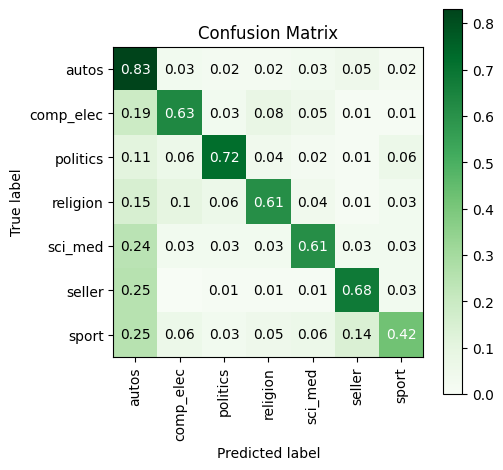

In [65]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_categories[i] for i in y_test], [target_categories[i] for i in y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Greens",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

### Custom Test

In [66]:
# define documents
docs = ['Democrats the Reuplicans are both the worst!',
'Coyotes win 10-0',
'Houston Astros defeat the Cubs',
'Apple and Microsoft both make great computers',
'New washer 4sale. $200']

doc_array = np.array(docs)

doc_array_vect  = pad_sequences(tokenizer.texts_to_sequences(doc_array), maxlen=max_tokens, padding="post", truncating="post", value=0.)

cstm_test_preds = model.predict(doc_array_vect).argmax(axis=-1)

1/1 [==============================] - 0s 21ms/step


In [67]:
print(doc_array)

['Democrats the Reuplicans are both the worst!' 'Coyotes win 10-0'
 'Houston Astros defeat the Cubs'
 'Apple and Microsoft both make great computers' 'New washer 4sale. $200']


In [68]:
print(doc_array_vect)

[[   2   53 3716    2 1299    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  69  199   47    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [2931 4257    2 1113    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [ 124    3  461 3716  277  580 1149    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

In [69]:
print(cstm_test_preds)

[2 6 6 1 3]
